In [1]:
from core import *
import requests, json

In [2]:
dataset_id = {
    'all': 'd_e39eeaeadb571c0d0725ef1eec48d166', 
}
dataset_mode = 'all'

In [3]:
response = requests.get(
    'https://data.gov.sg/api/action/datastore_search', 
    params={
        'resource_id': dataset_id[dataset_mode],
        'limit': 999
    }
)
print(json.dumps(response.json(), indent=2))

{
  "help": "https://data.gov.sg/api/3/action/help_show?name=datastore_search",
  "success": true,
  "result": {
    "resource_id": "d_e39eeaeadb571c0d0725ef1eec48d166",
    "fields": [
      {
        "type": "text",
        "id": "DataSeries"
      },
      {
        "type": "numeric",
        "id": "2024"
      },
      {
        "type": "numeric",
        "id": "2023"
      },
      {
        "type": "numeric",
        "id": "2022"
      },
      {
        "type": "numeric",
        "id": "2021"
      },
      {
        "type": "numeric",
        "id": "2020"
      },
      {
        "type": "numeric",
        "id": "2019"
      },
      {
        "type": "numeric",
        "id": "2018"
      },
      {
        "type": "numeric",
        "id": "2017"
      },
      {
        "type": "numeric",
        "id": "2016"
      },
      {
        "type": "numeric",
        "id": "2015"
      },
      {
        "type": "numeric",
        "id": "2014"
      },
      {
        "type": "numeri

In [4]:
data = response.json()
records = data['result']['records']
df = pd.DataFrame(records)
df['DataSeries'] = df['DataSeries'].str.strip()
# df['SubDataSeries'] = df['DataSeries'].str.extract(r'(?i)\b(male|female)s?\b').ffill()
df['DataSeries'] = df['DataSeries'].str.extract(r'(?i)\b(\d+.*)\b', expand=True)
df['DataSeries'] = df['DataSeries'].str.replace(r'(?i)\W*\byears?\b|\s+', '', regex=True).str.replace(r'(?i)\W*over\b', '+', regex=True).str.strip()
df = df.dropna(subset=['DataSeries'])
df = df.rename(columns={'DataSeries': 'age_group'}).drop(columns=['_id'])
df['age_group'] = pd.Categorical(df['age_group'], ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65+'], ordered=True)
for col in df.drop(columns=['age_group']).columns:
    try:
        df[col] = df[col].astype('float').div(1000)
    except:
        df[col] = df[col].str.strip().where(df[col].str.contains(r'\d+(?:\.\d+)?', na=False)).astype('float').div(1000)
df = df.groupby(by=['age_group'], observed=True).sum()
df = df.rename(columns=int).transpose().sort_index(axis=0).sort_index(axis=1).copy(deep=True)
# df = df.set_index(keys=['brides', 'grooms', 'comparison']).rename(columns=int).astype('int').transpose().sort_index(axis=0).sort_index(axis=1).copy(deep=True)
# df = df.set_index(keys=['brides', 'grooms']).rename(columns=int).astype('int').unstack(level=0).sort_index(axis=0).sort_index(axis=1).copy(deep=True)
assert isinstance(df, pd.DataFrame)
display_all_columns(df)

age_group,15-19,20-24,25-29,30-34,35-39,40-44,45-49
1960,0.0696,0.2505,0.3239,0.2597,0.1767,0.0707,0.0000
1961,0.0634,0.2411,0.3049,0.2384,0.1689,0.0648,0.0000
1962,0.0520,0.2455,0.2917,0.2315,0.1562,0.0651,0.0000
1963,0.0457,0.2490,0.2872,0.2287,0.1561,0.0649,0.0000
1964,0.0383,0.2400,0.2776,0.2267,0.1477,0.0628,0.0000
...,...,...,...,...,...,...,...
2020,0.0023,0.0127,0.0546,0.0908,0.0490,0.0095,0.0005
2021,0.0022,0.0117,0.0534,0.0929,0.0536,0.0102,0.0003
2022,0.0021,0.0112,0.0488,0.0867,0.0494,0.0098,0.0004
2023,0.0022,0.0106,0.0437,0.0787,0.0479,0.0096,0.0006


In [5]:
df_cohort = df.rename_axis(index='year').stack(level=['age_group']).reset_index(drop=False).copy(deep=True)
df_cohort['cohort'] = df_cohort['age_group'].str.extract(r'(?i)(\d+)')
df_cohort['cohort'] = df_cohort['year'].subtract(df_cohort['cohort'].astype('int')).map(lambda val: f'{val-4:.0f}-{val:.0f}')
for col in ['age_group']:
    df_cohort[col] = pd.Categorical(df_cohort[col], df_cohort[col].sort_values().unique(), ordered=True)
df_cohort = df_cohort.drop(columns=['year']).set_index(keys=['cohort', 'age_group'], append=False).iloc[:,0].sort_index().copy(deep=True)
df_cohort = df_cohort.unstack(level=['cohort']).sort_index(axis=1).sort_index(axis=0).copy(deep=True)
display_all_columns(df_cohort)

cohort,1911-1915,1912-1916,1913-1917,1914-1918,1915-1919,1916-1920,1917-1921,1918-1922,1919-1923,1920-1924,1921-1925,1922-1926,1923-1927,1924-1928,1925-1929,1926-1930,1927-1931,1928-1932,1929-1933,1930-1934,1931-1935,1932-1936,1933-1937,1934-1938,1935-1939,1936-1940,1937-1941,1938-1942,1939-1943,1940-1944,1941-1945,1942-1946,1943-1947,1944-1948,1945-1949,1946-1950,1947-1951,1948-1952,1949-1953,1950-1954,1951-1955,1952-1956,1953-1957,1954-1958,1955-1959,1956-1960,1957-1961,1958-1962,1959-1963,1960-1964,1961-1965,1962-1966,1963-1967,1964-1968,1965-1969,1966-1970,1967-1971,1968-1972,1969-1973,1970-1974,1971-1975,1972-1976,1973-1977,1974-1978,1975-1979,1976-1980,1977-1981,1978-1982,1979-1983,1980-1984,1981-1985,1982-1986,1983-1987,1984-1988,1985-1989,1986-1990,1987-1991,1988-1992,1989-1993,1990-1994,1991-1995,1992-1996,1993-1997,1994-1998,1995-1999,1996-2000,1997-2001,1998-2002,1999-2003,2000-2004,2001-2005,2002-2006,2003-2007,2004-2008,2005-2009
age_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0696,0.0634,0.0520,0.0457,0.0383,0.0359,0.0330,0.0358,0.0309,0.0271,0.0259,0.0256,0.0253,0.0242,0.0208,0.0168,0.0162,0.0134,0.0118,0.0114,0.0127,0.0118,0.0114,0.0104,0.0103,0.0096,0.0086,0.0077,0.0073,0.0072,0.0083,0.0084,0.0079,0.0083,0.0074,0.0066,0.0068,0.0068,0.0075,0.0084,0.0088,0.0084,0.0080,0.0067,0.0066,0.0072,0.0066,0.0061,0.0061,0.0050,0.0048,0.0047,0.0043,0.0038,0.0033,0.0027,0.0027,0.0026,0.0025,0.0025,0.0023,0.0022,0.0021,0.0022,0.0023
20-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2505,0.2411,0.2455,0.2490,0.2400,0.2271,0.2185,0.1958,0.1658,0.1501,0.1390,0.1383,0.1374,0.1305,0.1189,0.1021,0.1072,0.0903,0.0868,0.0851,0.0849,0.0842,0.0802,0.0724,0.0686,0.0680,0.0604,0.0597,0.0650,0.0597,0.0587,0.0535,0.0521,0.0498,0.0469,0.0469,0.0448,0.0420,0.0397,0.0373,0.0422,0.0357,0.0346,0.0324,0.0322,0.0325,0.0306,0.0312,0.0291,0.0254,0.0233,0.0224,0.0222,0.0197,0.0195,0.0187,0.0170,0.0151,0.0144,0.0127,0.0127,0.0117,0.0112,0.0106,0.0098,NaN,NaN,NaN,NaN,NaN
25-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3239,0.3049,0.2917,0.2872,0.2776,0.2595,0.2612,0.2447,0.2366,0.2278,0.2088,0.2126,0.2180,0.1995,0.1722,0.1545,0.1602,0.1389,0.1409,0.1393,0.1445,0.1412,0.1364,0.1255,0.1242,0.1239,0.1101,0.1248,0.1475,0.1297,0.1360,0.1292,0.1284,0.1300,0.1292,0.1256,0.1228,0.1169,0.1052,0.1051,0.1101,0.0962,0.0916,0.0822,0.0806,0.0807,0.0796,0.0787,0.0789,0.0742,0.0681,0.0734,0.0767,0.0705,0.0711,0.0687,0.0658,0.0622,0.0606,0.0594,0.0546,0.0534,0.0488,0.0437,0.0426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2597,0.2384,0.2315,0.2287,0.2267,0.2162,0.2020,0.1667,0.1520,0.1343,0.1380,0.1376,0.1392,0.1284,0.1029,0.0949,0.0959,0.0852,0.0868,0.0884,0.0878,0.0842,0.0845,0.0799,0.0830,0.0856,0.0744,0.0925,0.1189,0.1045,0.1108,0.1068,0.1072,0.1088,0.1092,0.1074,0.1085,0.1073,0.0961,0.0975,0.1079,0.0949,0.0962,0.0900,0.0899,0.0892,0.0931,0.0944,0.0946,0.0901,0.0860,0.0895,0.0995,0.0902,0.0993,0.0985,0.0962,0.0933,0.0929,0.0924,0.0908,0.0929,0.0867,0.0787,0.0793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35-39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1767,0.1689,0.1562,0.1561,0.1477,0.1381,0.1248,0.0959,0.0852,0.0752,0.0745,0.0685,0.0661,0.0576,0.0426,0.0363,0.0338,0.0287,0.0267,0.0275,0.0280,0.0293,0.0310,0.0295,0.0321,0.0311,0.0284,0.0335,0.0449,0.0421,0.0443,0.0417,0.0417,0.0436,0.0426,0.0413,0.0426,0.0417,0.0398,0.0386,0.0433,0.0395,0.0382,0.0363,0.0356,0.0368,0.0387,0.0415,0.0415,0.0426,0.0422,0.0424,0.0463,0.0447,0.0483,0.0499,0.0497,0.0486,0.0484,0.0501,0.0490,0.0536,0.0494,0.0479,0.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40-44,NaN,NaN,NaN,NaN,NaN,0.0707,

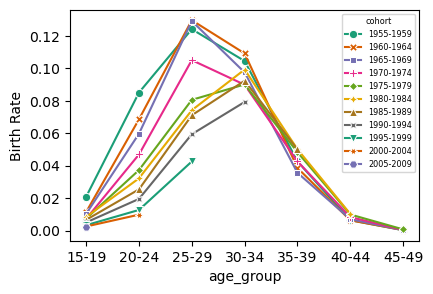

In [11]:
fig, axs = plot_singlecol_data(df_cohort.loc[:,df_cohort.iloc[:,-51::5].columns], ylabel='Birth Rate', splitplot=False)
# fig.savefig(f'./rate_{dataset_mode}.svg', transparent=False, format='svg', bbox_inches='tight')
plt.show()
fig.clf()
plt.close()

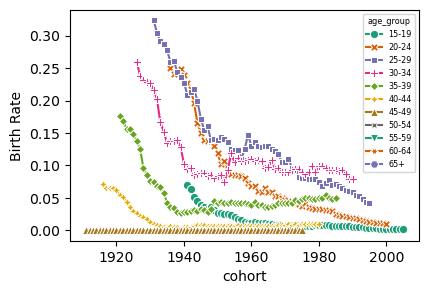

In [12]:
fig, axs = plot_singlecol_data(df_cohort.T.rename(index=lambda val: int(val.split('-')[0])), ylabel='Birth Rate', splitplot=False)
# fig.savefig(f'./rate_{dataset_mode}.svg', transparent=False, format='svg', bbox_inches='tight')
plt.show()
fig.clf()
plt.close()